In [1]:
## Updated by gavento based on code by Sudarsh

from transformer_lens import HookedTransformer
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.neighbors import BallTree

# Load the pre-trained model
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


model = HookedTransformer.from_pretrained("gpt2-medium", device=device)
# gemma_model = HookedTransformer.from_pretrained("gemma-2b", device="mps")
torch.set_printoptions(threshold=1_000_000)
torch.set_printoptions(linewidth=1_000_000)

/usr/local/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-medium into HookedTransformer


In [2]:
# Define the input text
input_text = """Relative entropy is always a non-negative real number, with value 0 if and only if the two distributions in question are identical. It has diverse applications, both theoretical, such as characterizing the relative (Shannon) entropy in information systems, randomness in continuous time-series, and information gain when comparing statistical models of inference; and practical, such as applied statistics, fluid mechanics, neuroscience, bioinformatics, and machine learning."""

# Tokenize the input text
tokens = model.to_tokens(input_text)[:, 1:] # Skip BOS
print(tokens.shape, tokens)
print(model.tokenizer.convert_ids_to_tokens(tokens[0]))

# 
# embeddings_tree = BallTree(W_E.numpy(), leaf_size=1)

SOFT_TOKENS = 10
MODEL_DIM = 1024
L2REG = 0.5

def exec_model(model, first_tokens_embedding, tokens):
    residual, _tks, _spe, _attn = model.input_to_embed(tokens)

    skip = first_tokens_embedding.shape[1]
    both = torch.concat([first_tokens_embedding, residual], axis=1)
    #print(first_tokens_embedding.shape, residual.shape, both.shape)
    return model(both, start_at_layer=0)

def predict(model, first_tokens_embedding, num_tokens):
    tokens = []
    skip = first_tokens_embedding.shape[1]
    for i in range(num_tokens):
        toks = torch.tensor(tokens, dtype=torch.long)
        residual, _tks, _spe, _attn = model.input_to_embed(toks)
        both = torch.concat([first_tokens_embedding.detach(), residual], axis=1)
        res = model(both, start_at_layer=0)[0]
        next_token = torch.argmax(res, axis=-1)[-1].item()  # Get the last token predicted
        tokens.append(next_token)
        probs = torch.softmax(res, axis=-1)
        #print(model.tokenizer.convert_ids_to_tokens(tokens))
        #print(residual.shape, toks.shape, both.shape, res.shape, probs.shape)
    
    return (model.tokenizer.decode(tokens),
            model.tokenizer.convert_ids_to_tokens(tokens),
            torch.tensor(tokens).cpu())  # Convert the final token list to a tensor

def nearest_neighbour_loss(x, ball_tree, W_E): 
    # Get the nearest neighbour
    dist, ind = ball_tree.query(x.detach().cpu().numpy(), k=1)
    nearest_neighbour = W_E[ind].to(device)

    # then we calculate the distance between x and its nearest neighbour
    distance = torch.norm(x - nearest_neighbour, p=2)
    return distance

def token_alignment_loss(logits, tokens, first_tokens_embedding, alpha=1.0, beta=0.7, kappa=0.1, gamma=0.2):
    # Calculate the cross-entropy loss
    def l2(x): return torch.sum(x ** 2) ** 0.5

    logits = logits[SOFT_TOKENS - 1:-1, :]

    ce_loss = F.cross_entropy(logits, tokens)
    
    # Calculate the token matching loss
    # pred_tokens = torch.argmax(logits, dim=-1)
    # match_loss = (pred_tokens != tokens).float().mean()
    
    # L2 regularization
    l2_loss = l2(first_tokens_embedding)

    # # do nearest neighbour loss for each token in first_tokens_embedding
    # nn_loss = 0
    # for i in range(first_tokens_embedding.shape[1]):
    #     nn_loss += nearest_neighbour_loss(first_tokens_embedding[:, i, :], embeddings_tree, W_E)
    
    # Combine the losses
    # total_loss = alpha * match_loss + beta * ce_loss + gamma * l2_loss #+ kappa * nn_loss

    total_loss = ce_loss + gamma * l2_loss

    return total_loss



torch.Size([1, 90]) tensor([[ 6892,   876, 40709,   318,  1464,   257,  1729,    12, 31591,  1103,  1271,    11,   351,  1988,   657,   611,   290,   691,   611,   262,   734, 24570,   287,  1808,   389, 10411,    13,   632,   468, 10084,  5479,    11,  1111, 16200,    11,   884,   355,  2095,  2890,   262,  3585,   357,  2484,  8825,     8, 40709,   287,  1321,  3341,    11,  4738,  1108,   287, 12948,   640,    12, 25076,    11,   290,  1321,  4461,   618, 14176, 13905,  4981,   286, 32278,    26,   290,  8472,    11,   884,   355,  5625,  7869,    11, 11711, 12933,    11, 39738,    11, 13401,   259, 18982,   873,    11,   290,  4572,  4673,    13]], device='cuda:0')
['Rel', 'ative', 'Ġentropy', 'Ġis', 'Ġalways', 'Ġa', 'Ġnon', '-', 'negative', 'Ġreal', 'Ġnumber', ',', 'Ġwith', 'Ġvalue', 'Ġ0', 'Ġif', 'Ġand', 'Ġonly', 'Ġif', 'Ġthe', 'Ġtwo', 'Ġdistributions', 'Ġin', 'Ġquestion', 'Ġare', 'Ġidentical', '.', 'ĠIt', 'Ġhas', 'Ġdiverse', 'Ġapplications', ',', 'Ġboth', 'Ġtheoretical', ',', 'Ġs

0

Step 0, Maximum Correct=0, Correct=0, Loss=30.06426429748535/0, L2=102.71237182617188, LR=[0.19894313879210052], Pred='.\n.\n.\n.\n.\nThe word.The word "n" is a'
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50

Step 50, Maximum Correct=20, Correct=20, Loss=9.686123847961426/5, L2=45.36923599243164, LR=[0.15264320137581455], Pred='Relative entropy is always a non-negative real number, with value 0 if and only if the'
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100

Step 100, Maximum Correct=25, Correct=25, Loss=8.452168464660645/10, L2=41.23023223876953, LR=[0.1171186252902463], Pred='Relative entropy is always a non-negative real number, with value 0 if and only if the two distributions in question are'
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


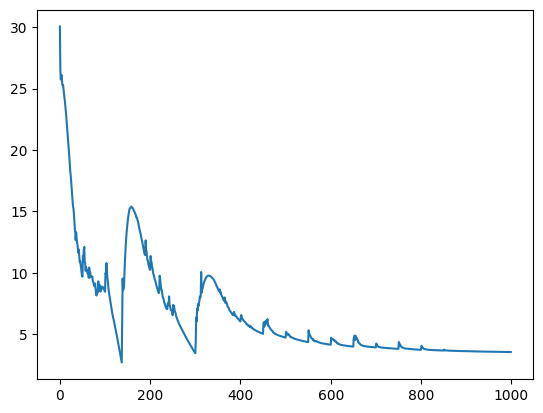

In [4]:
import math

first_tokens_embedding = torch.randn(size=(1, SOFT_TOKENS, MODEL_DIM), dtype=torch.float32, device=device)
if device == "cuda": 
    first_tokens_embedding = first_tokens_embedding.cuda()
if device == "mps":
    first_tokens_embedding = first_tokens_embedding.to(torch.float32).to(device)

first_tokens_embedding = first_tokens_embedding.requires_grad_(True)

num_steps = 1000  # Number of optimization steps
# Define the optimizer for the first tokens' embedding
optimizer = torch.optim.Adam([first_tokens_embedding], lr=0.02 * SOFT_TOKENS, amsgrad=True)
# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.005 ** (1/num_steps), verbose=True)

loss_arr = []

def l2(x): return torch.sum(x ** 2) ** 0.5

last_corr = 0
max_corr = 0
lossahead = 5 + SOFT_TOKENS * 2
lookahead = 20
kappa = 0.1
alpha = 0.0
beta = 1.0
for step in range(num_steps):
    # Zero the gradients
    optimizer.zero_grad()

    # Replace the first token's embedding in the reg_embeddings tensor
    logits = exec_model(model, first_tokens_embedding, tokens)
    #print(logits.shape)
    # Calculate the loss
    # loss = F.cross_entropy(logits.flatten(0, 1)[:last_corr+lossahead], tokens.flatten(0, 1)[:last_corr+lossahead]) + L2REG * l2(first_tokens_embedding)

    flattened_logits = logits.flatten(0, 1)[:last_corr+lookahead+SOFT_TOKENS]
    flattened_tokens = tokens.flatten(0, 1)[:last_corr+lookahead]

    loss = token_alignment_loss(flattened_logits, flattened_tokens, first_tokens_embedding, alpha=0.0, beta=1.0)
    
    # Backpropagate the loss with retain_graph=True
    loss.backward()

    # Optimize the first token's embedding
    optimizer.step()
    lr_scheduler.step()

    loss_arr.append(loss.item())

    # Print the loss for every 100 steps
    print(step)
    if step % 50 == 0:
        with torch.no_grad():  # Disable gradient computation for prediction

            ps = predict(model, first_tokens_embedding, last_corr+lookahead)
            temp_corr = (ps[2][:min(last_corr+lookahead, tokens.shape[1])] == tokens[:, :last_corr+lookahead].cpu()).sum()
            max_corr = max(temp_corr, max_corr)
            if temp_corr > last_corr:
                last_corr += math.ceil((temp_corr - last_corr) / 4)
            print(f"\nStep {step}, Maximum Correct={max_corr}, Correct={temp_corr}, Loss={loss.item()}/{last_corr}, L2={l2(first_tokens_embedding).detach().cpu()}, LR={lr_scheduler.get_last_lr()}, Pred={ps[0]!r}")
    

    # just comment out this part if you want to not add tokens
    # if step % 20 == 0 and step != 0:
    #     new_tokens_embedding = torch.tensor(np.random.normal(0.0, 768**(-0.5), size=(1, 1, MODEL_DIM)), dtype=torch.float32, requires_grad=True).to(device)
    #     print("ADDING NEW TOK")
    #     first_tokens_embedding = torch.cat([ new_tokens_embedding, first_tokens_embedding], dim=1)
    #     first_tokens_embedding = first_tokens_embedding.detach().requires_grad_(True)

    #     # Reinitialize the optimizer with the updated embedding
    #     optimizer = torch.optim.Adam([first_tokens_embedding], lr=0.02, amsgrad=True)
    #     lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.005 ** (1/num_steps), verbose=True)


plt.plot(loss_arr)

In [5]:
# The prediction runs only given the following tensor shaped (1,1,768):
MAGIC = first_tokens_embedding
# Compare the following:
print(repr(predict(model, MAGIC, 90)[0]))
print(repr(input_text))

'Relative entropy is always a non-negative real number, with value 0 if and only if the two distributions in question are identical. It has diverse applications, both theoretical, such as characterizing the relative (Shannon) entropy in information systems, randomness in continuous time-series, and information gain when comparing statistical models of inference; and practical, such as applied statistics, fluid mechanics, neuroscience, bioinformatics, and machine learning.'
'Relative entropy is always a non-negative real number, with value 0 if and only if the two distributions in question are identical. It has diverse applications, both theoretical, such as characterizing the relative (Shannon) entropy in information systems, randomness in continuous time-series, and information gain when comparing statistical models of inference; and practical, such as applied statistics, fluid mechanics, neuroscience, bioinformatics, and machine learning.'


In [6]:
precious = first_tokens_embedding

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import random

# I use small models because I'm GPU poor
model1 = "gpt2-medium"
model2 = "gpt2"

# Load the models
model1_tokenizer = AutoTokenizer.from_pretrained(model1)
model2_tokenizer = AutoTokenizer.from_pretrained(model2)

model1_vocab_dict = model1_tokenizer.get_vocab()
model2_vocab_dict = model2_tokenizer.get_vocab()
model1_vocab = set(model1_vocab_dict.keys())
model2_vocab = set(model2_vocab_dict.keys())
intersection = list(model1_vocab.intersection(model2_vocab))

# now we need to get the embedding matrix for each model
model1_model = AutoModelForCausalLM.from_pretrained(model1)
model2_model = AutoModelForCausalLM.from_pretrained(model2)

model1_embedding_matrix = model1_model.get_input_embeddings().weight.data
model2_embedding_matrix = model2_model.get_input_embeddings().weight.data

A = model1_embedding_matrix[model1_tokenizer.convert_tokens_to_ids(intersection)]
B = model2_embedding_matrix[model2_tokenizer.convert_tokens_to_ids(intersection)]

print(A.shape, B.shape)

# we need to find the average vector in A
A_avg = torch.mean(A, axis=0)
B_avg = torch.mean(B, axis=0)

# now we subtract the average vector from each vector in A and B
A = A - A_avg
B = B - B_avg

# split A and B into 90, 10
A_train = A[: int(0.9 * len(A))]
A_test = A[int(0.9 * len(A)) :]
B_train = B[: int(0.9 * len(B))]
B_test = B[int(0.9 * len(B)) :]

# then we need to create a matrix W
# then minimizing ||AW - B||^2

W, residuals, rank, singular_values = torch.linalg.lstsq(A_train, B_train)

torch.Size([50257, 1024]) torch.Size([50257, 768])


In [10]:
# transform precious

precious_transformed = precious[0, :, :].unsqueeze(0).to("cpu")
precious_transformed = precious_transformed - A_avg
precious_transformed = precious_transformed @ W
precious_transformed = precious_transformed + B_avg
print(precious_transformed.shape)
print(precious.shape)

print(precious_transformed.shape)

torch.Size([1, 10, 768])
torch.Size([1, 10, 1024])
torch.Size([1, 10, 768])


In [11]:
precious_transformed = precious_transformed.to("cuda")

In [12]:
from transformer_lens import HookedTransformer
import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.neighbors import BallTree

# Load the pre-trained model
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


model = HookedTransformer.from_pretrained("gpt2", device=device)
# gemma_model = HookedTransformer.from_pretrained("gemma-2b", device="mps")
torch.set_printoptions(threshold=1_000_000)
torch.set_printoptions(linewidth=1_000_000)

Loaded pretrained model gpt2 into HookedTransformer


In [13]:
predictions = predict(model, precious_transformed, 100)
print(predictions[0])

 -, in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the in the
